<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'/>

<hr>

# MTG FCI and S3 for fires: visualising FCI L1c RGBs, FIR Active Fire Monitoring product and S3 NRT Fire detections

Author: Andrea Meraner (EUMETSAT). Containing parts of notebooks originally developed by Dominika Czyzewska (EUM) and Noemi Fazzini (MEEO)

### Data used

|                    Product Description                     | Data Store collection ID |                     Product Navigator                      |
|:----------------------------------------------------------:|:------------------------:|:----------------------------------------------------------:|
|      Active Fire Monitoring (netCDF) - MTG - 0 degree      |     EO:EUM:DAT:0682      | [link](https://vdata.eumetsat.int/product/EO:EUM:DAT:0682) |
| FCI Level 1c Normal Resolution Image Data - MTG - 0 degree |     EO:EUM:DAT:0662      | [link](https://vdata.eumetsat.int/product/EO:EUM:DAT:0662) |
|  FCI Level 1c High Resolution Image Data - MTG - 0 degree  |     EO:EUM:DAT:0665      | [link](https://vdata.eumetsat.int/product/EO:EUM:DAT:0665) |
| SLSTR Level 2 Fire Radiative Power in NRT - Sentinel-3  | EO:EUM:DAT:0417 | [link](https://navigator.eumetsat.int/product/EO:EUM:DAT:0207) |


This notebook demonstrates how to access, load, and visualise the [Active Fire Monitoring product (FIR)](https://vdata.eumetsat.int/product/EO:EUM:DAT:0682) product derived from Meteosat Third Generation (MTG) geostationary imager data. The FIR product detects and characterises active fires within pixels using the FCI IR-3.8 μm channel, which is highly sensitive to fire hotspots.

In addition, [FCI Level 1c Normal Resolution Image Data](https://vdata.eumetsat.int/product/EO:EUM:DAT:0662) consists of a set of files that contain the level 1c science data rectified to a reference grid together with the auxiliary data associated with the processing configuration and the quality assessment of the dataset. [FCI Level 1c High Resolution Image Data](https://vdata.eumetsat.int/product/EO:EUM:DAT:0665) contains 4 channels (VIS0.6, NIR2.2, IR3.8, and IR10.5) at an additional high resolution (500m for the VISNIR channels and 1km for the IR channels).

At the end, we also load and compare Sentinel-3 NRT Fire product detections with the FCI imagery.

As a case study, this notebook explores the Iberian Pennisula wildfires of summer 2025, combining FIR datasets with True Colour RGB composites to illustrate fire monitoring capabilities under varying conditions of cloud cover and surface features.



#### Load required libraries

In [1]:
import datetime
import numpy as np
from satpy.scene import Scene
from satpy import find_files_and_readers
from satpy.writers import get_enhanced_image
from pyresample import create_area_def

import warnings
from cartopy.io import DownloadWarning
import xarray as xr

from download_from_archive import download_from_eumdac
import credentials

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import cm
import cartopy.crs as ccrs


warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DownloadWarning)


/tmp/ipykernel_3908758/711772345.py:6: UserWarning: 'satpy.writers.get_enhanced_image' has been moved to 'satpy.enhancements.enhancer.get_enhanced_image'. Import from the new location instead (ex. 'from satpy.enhancements.enhancer import get_enhanced_image'). The old import paths will be removed in Satpy 1.0
  from satpy.writers import get_enhanced_image
/tcenas/home/andream/src/nero_gh/nero-winter-school-2025/get_fci_chunks_for_area.py:14: UserWarning: 'satpy.resample.get_area_def' has been moved to 'satpy.area.get_area_def'. Import from the new location instead (ex. 'from satpy.area import get_area_def'). The old import paths will be removed in Satpy 1.0
  from satpy.resample import get_area_def


#### Set the bounding box of the area of interest and the start-end datetimes to analyse

<div class="alert alert-block alert-warning">
<b>NOTE:</b><br />
For the notebook to work correctly, use a round 10 minutes start-end time interval (the FCI products are available every 10 minutes).
</div>

<div class="alert alert-block alert-success">
<b>Assignment:</b><br />
Enter your own bounding box and start-end time interval below.
</div>

In [2]:
latmin = 39.0000
latmax= 43.7914
lonmin= -9.5600
lonmax= -0.5

# format is ISO, e.g. "2025-08-18T16:00:00""
start_time = "2025-08-18T16:00:00"
end_time = "2025-08-18T16:10:00"

In [3]:
# we also define the output folder where the downloaded products will be stored
output_folder = "products/"

#### Set the resolution of the target analysis area definition and create the according pyresample AreaDefinition object

In [4]:
resolution = 1000. #m

def get_local_mercator_area(target_proj, area_extent, resolution):
    x_min, y_min = target_proj.transform_point(area_extent[0], area_extent[1], ccrs.PlateCarree()) # compute coordinates in target projection
    x_max, y_max = target_proj.transform_point(area_extent[2], area_extent[3], ccrs.PlateCarree())
    shape = [int((y_max - y_min) / resolution[0]), int((x_max - x_min) / resolution[1])] # compute the shape of the area in pixels
    adef = create_area_def('local_mercator_area', target_proj, area_extent=area_extent, units='degrees', shape=shape)
    return adef

target_proj = ccrs.Mercator()
adef = get_local_mercator_area(target_proj, [lonmin, latmin, lonmax, latmax], [resolution, resolution])
print(adef)

Area ID: local_mercator_area
Description: local_mercator_area
Projection: {'ellps': 'WGS84', 'k': '1', 'lon_0': '0', 'no_defs': 'None', 'proj': 'merc', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 1008
Number of rows: 708
Area extent: (-1064214.332, 4694777.2716, -55659.7454, 5403637.4821)


## Load and visualise FCI Level 1c Data

### Download FCI L1c data from the Datastore through the EUMDAC interface.

<div class="alert alert-block alert-warning">
<b>NOTE:</b><br />
Before running this section, remember to edit the credentials.py file with your personal API credentials for EUMDAC. You can find your personal API credentials here: <a href="https://api.eumetsat.int/api-key/">https://api.eumetsat.int/api-key/</a>
</div>

The following cell calls the `download_from_archive.download_from_eumdac` that is a custom wrapper around the EUMDAC API. The following cell shows the function docstring giving some extra information.

In [5]:
help(download_from_eumdac)

Help on function download_from_eumdac in module download_from_archive:

download_from_eumdac(start_time, end_time, collection_ids, output_folder, eumdac_key, eumdac_secret, run_name='', file_endings=None, fci_l1c_chunks_lonlat_bbox=None, search_bbox=None, create_tarball=False, n_parallel_downloads=4)
    Downloads EUMETSAT data products from the EUMDAC archive.
    
    Some of the custom features:
    - can filter FCI L1c chunks based on a lon/lat bounding box
    - can filter LEO products based on a lon/lat bounding box
    - adapts the search start/end times so that L2 products are retrieved correctly (avoids start/end overlap issue)
    - downloads using multiple processes
    
    Args:
        start_time (str): Start time in ISO format 'YYYY-MM-DDThh:mm:ss'
        end_time (str): End time in ISO format 'YYYY-MM-DDThh:mm:ss'
        collection_ids (list): List of EUMETSAT collection IDs to download
        output_folder (str): Local directory path to store downloaded files
      

Now let's download the FCI L1c data. The FCI L1c data is split in 40 horizontal chunks, that when stacked vertically together, compose a full-disc image (see [this guide for a plot of the chunks location](https://user.eumetsat.int/resources/user-guides/mtg-data-access-guide#ID-Download-chunks-of-FCI-products-based-on-coverage)). Adding the `fci_l1c_chunks_lonlat_bbox` argument lets the code only download chunks that intersect the bounding box.

<div class="alert alert-block alert-success">
<b>Assignment:</b><br />
Can you think of some good reasons for why the FCI L1c data is split in horizontal chunks?
</div>

In [6]:
# geographical bounds of search area (used for FCI L1c chunks selection)
fci_l1c_chunks_lonlat_bbox = [lonmin, latmin, lonmax, latmax]

collection_ids = ["EO:EUM:DAT:0662", "EO:EUM:DAT:0665"]

download_from_eumdac(start_time, end_time, collection_ids, output_folder,
                     credentials.EUMDAC_CONSUMER_KEY, credentials.EUMDAC_CONSUMER_SECRET, file_endings=['.nc'],
                     fci_l1c_chunks_lonlat_bbox=fci_l1c_chunks_lonlat_bbox)


[2025-09-19 20:25:37] [DEBUG] download_from_archive: DataStore initialized.
[2025-09-19 20:25:39] [INFO] download_from_archive: Found 1 products for collection_id EO:EUM:DAT:0662 with type MTIFCI1CRRADFDHSI and time range 2025-08-18 16:00:00 to 2025-08-18 16:10:00.
[2025-09-19 20:25:39] [INFO] download_from_archive: Found 1 products for collection_id EO:EUM:DAT:0665 with type MTIFCI1CRRADHRFI and time range 2025-08-18 16:00:00 to 2025-08-18 16:10:00.
[2025-09-19 20:25:40] [INFO] download_from_archive: Will be retrieving chunks: [34, 35]
[2025-09-19 20:25:40] [INFO] download_from_archive: File products/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4E_C_EUMT_20250818161050_IDPFI_OPE_20250818160810_20250818160904_N__O_0097_0035.nc already exists, skipping download.
[2025-09-19 20:25:40] [INFO] download_from_archive: File products/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4E_C_EUMT_20250818161041_IDPFI_OPE_20250818160752_2025081816085

FYI: MTG products follow the WMO file naming convention. You can find more information about this in our User Portal guide: <a href="https://user.eumetsat.int/resources/user-guides/mtg-fci-level-1c-data-guide#ID-Naming-convention">https://user.eumetsat.int/resources/user-guides/mtg-fci-level-1c-data-guide#ID-Naming-convention</a>
</div>

## Visualise the FCI data using the Satpy Scene

You can now use the `Scene` constructor from the [satpy](https://satpy.readthedocs.io/en/stable/index.html) library to load the data files. Once loaded, a `Scene` object represents a single geographic region and time slot of data.

The Satpy Scene accepts both FDHSI and HRFI data chunks at the same time, and will automatically pick the channels with the best available resolution by default.

In [7]:
fci_files = find_files_and_readers(base_dir=output_folder, reader='fci_l1c_nc', start_time=datetime.datetime.strptime(start_time, "%Y-%m-%dT%H:%M:%S"), end_time=datetime.datetime.strptime(end_time, "%Y-%m-%dT%H:%M:%S"))
fci_l1_scn = Scene(filenames=fci_files)

Here you will be able to select the RGB composite you want to display. You can browse the pre-defined composites using the according function

In [8]:
fci_l1_scn.available_composite_names()

['24h_microphysics',
 'airmass',
 'ash',
 'cimss_cloud_type',
 'cimss_cloud_type_raw',
 'cloud_phase',
 'cloud_phase_distinction',
 'cloud_phase_distinction_raw',
 'cloud_phase_raw',
 'cloud_phase_with_night_ir105',
 'cloud_type',
 'cloud_type_with_night_ir105',
 'cloudtop',
 'colorized_ir_clouds',
 'convection',
 'day_essl_colorized_low_level_moisture',
 'day_essl_low_level_moisture',
 'day_microphysics',
 'day_severe_storms',
 'day_severe_storms_tropical',
 'dust',
 'essl_colorized_low_level_moisture',
 'essl_low_level_moisture',
 'fci_fire_channels_sum',
 'fire_temperature',
 'fire_temperature_38refl',
 'fire_temperature_rad',
 'flames_masked',
 'fog',
 'geo_color',
 'geo_color_background_with_low_clouds',
 'geo_color_high_clouds',
 'geo_color_low_clouds',
 'geo_color_night',
 'green_snow',
 'hrv_clouds',
 'ir108_3d',
 'ir_cloud_day',
 'ir_sandwich',
 'ir_sandwich_with_night_colorized_ir_clouds',
 'natural_color',
 'natural_color_raw',
 'ndvi_hybrid_green',
 'ndvi_hybrid_green_fully


We choose to display a True Color RBG (Fun fact: the [FCI First Image](https://www.eumetsat.int/features/discover-first-images-mtg-i1) was created using Satpy and this very composite):

In [9]:
composite1 = 'true_color'
fci_l1_scn.load([composite1], upper_right_corner='NE', pad_data=False)

The following datasets were not created and may require resampling to be generated: DataID(name='true_color')


Next, you can use the area definition above in order to resample the loaded Scene object. For some composites, this is a must, as channels with different spatial resolutions need to be combined in the same image.
You can use the method `Scene.resample()` to do so. Afterwards, we call `get_enhanced_image` to generate the composite, including all the spectral stretchings, enhancements and corrections.

In [10]:
scn_resampled_color = fci_l1_scn.resample(adef)
xr_color = get_enhanced_image(scn_resampled_color["true_color"])
composite1_img = np.moveaxis(xr_color.data.to_numpy(), 0, -1)

SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 




You can now print the metadata of the loaded image

In [11]:
print(scn_resampled_color)

<xarray.DataArray 'where-ab623348a8ce9d145e568354c458c150' (bands: 3, y: 708,
                                                            x: 1008)> Size: 9MB
dask.array<where, shape=(3, 708, 1008), dtype=float32, chunksize=(1, 708, 1008), chunktype=numpy.ndarray>
Coordinates:
    crs      object 8B PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["Unknown...
  * y        (y) float64 6kB 5.403e+06 5.402e+06 ... 4.696e+06 4.695e+06
  * x        (x) float64 8kB -1.064e+06 -1.063e+06 ... -5.716e+04 -5.616e+04
  * bands    (bands) <U1 12B 'R' 'G' 'B'
Attributes: (12/21)
    standard_name:           true_color
    platform_name:           Meteosat-12
    orbital_parameters:      {'satellite_actual_longitude': -0.37285876274108...
    area:                    Area ID: local_mercator_area\nDescription: local...
    grid_mapping:            mtg_geos_projection
    _FillValue:              65535
    ...                      ...
    resolution:              500
    _satpy_id:               DataID(na

Afterwards, you can visualize the resampled `true_color` RGB with the method `Scene.show()`.

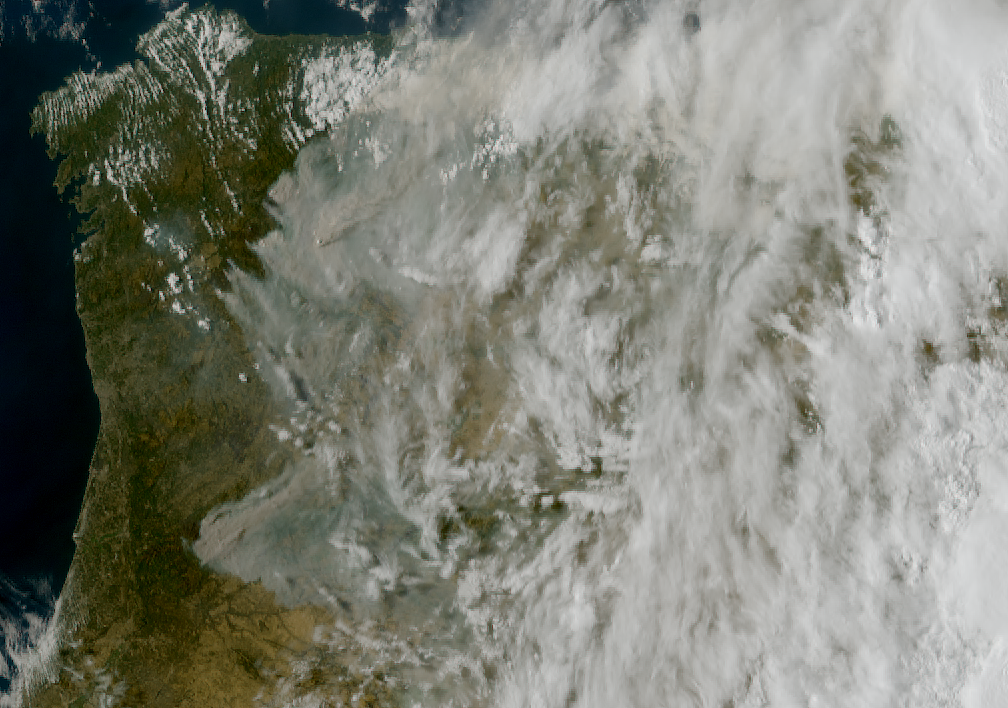

In [12]:
scn_resampled_color.show(composite1)

The same thing can be done with channel/RGB composite `fire_temperature`. More information about this RGB can be found [here](https://user.eumetsat.int/resources/user-guides/fire-temperature-rgb-quick-guide).

The following datasets were not created and may require resampling to be generated: DataID(name='true_color'), DataID(name='fire_temperature')


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 




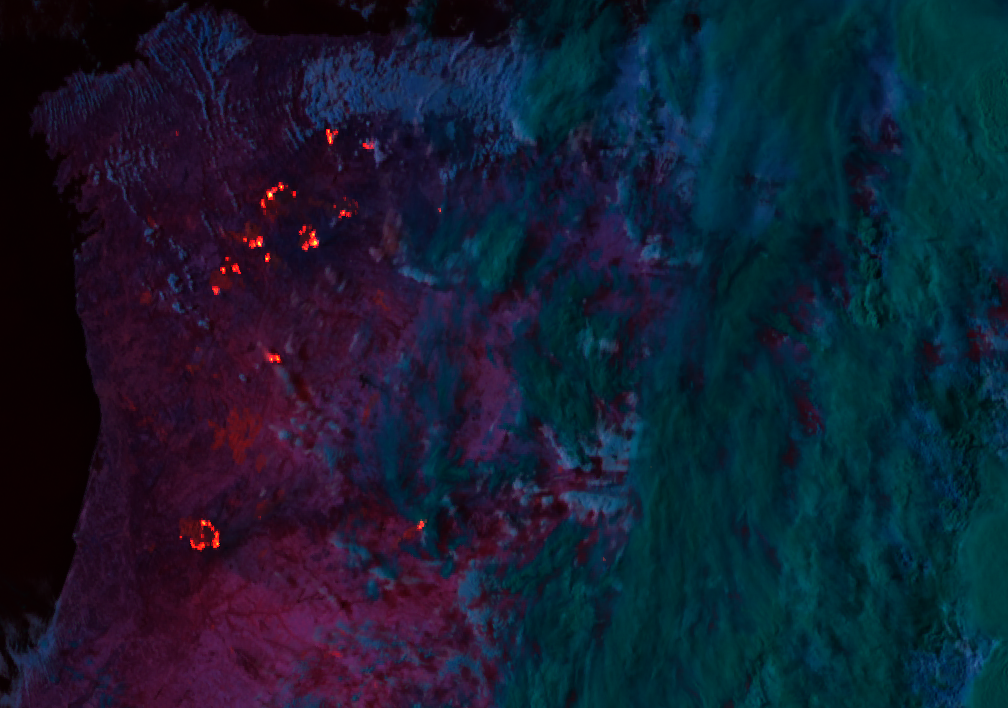

In [13]:
composite2='fire_temperature'
fci_l1_scn.load([composite2], upper_right_corner='NE', pad_data=False)

scn_resampled_temp = fci_l1_scn.resample(adef)
xr_temp = get_enhanced_image(scn_resampled_temp["fire_temperature"])
composite2_img = np.moveaxis(xr_temp.data.to_numpy(), 0, -1)

scn_resampled_temp.show(composite2)

## Analyse RGB components

Now, let's analyse the RGB components of the Fire Temperature composite. You can find the used channels in the quick guide linked above, as well as this [NOAA quick guide](https://www.star.nesdis.noaa.gov/GOES/documents/QuickGuide_Fire_Temperature_RGB.pdf), that contains also the RGB stretch limits.

The cell below gives you the list of available channels in the FCI Scene.

In [14]:
fci_l1_scn.available_dataset_names()

['ir_105',
 'ir_105_earth_sun_distance',
 'ir_105_index_map',
 'ir_105_pixel_quality',
 'ir_105_platform_altitude',
 'ir_105_subsatellite_latitude',
 'ir_105_subsatellite_longitude',
 'ir_105_subsolar_latitude',
 'ir_105_subsolar_longitude',
 'ir_105_sun_satellite_distance',
 'ir_105_swath_direction',
 'ir_105_swath_number',
 'ir_105_time',
 'ir_123',
 'ir_123_earth_sun_distance',
 'ir_123_index_map',
 'ir_123_pixel_quality',
 'ir_123_platform_altitude',
 'ir_123_subsatellite_latitude',
 'ir_123_subsatellite_longitude',
 'ir_123_subsolar_latitude',
 'ir_123_subsolar_longitude',
 'ir_123_sun_satellite_distance',
 'ir_123_swath_direction',
 'ir_123_swath_number',
 'ir_123_time',
 'ir_133',
 'ir_133_earth_sun_distance',
 'ir_133_index_map',
 'ir_133_pixel_quality',
 'ir_133_platform_altitude',
 'ir_133_subsatellite_latitude',
 'ir_133_subsatellite_longitude',
 'ir_133_subsolar_latitude',
 'ir_133_subsolar_longitude',
 'ir_133_sun_satellite_distance',
 'ir_133_swath_direction',
 'ir_133_sw

<div class="alert alert-block alert-success">
<b>Assignment:</b><br />
Based on the information above, enter the channels that you want to display in the `channels` list (as string items). Afterwards, adapt the `vmins` and `vmaxs` list values as you see fit - what are the units of the different channels?
Observe how the colormap limits of the RGB influence each RGB component appearance - how does this translate into the visual appearance of the RGB?
</div>


In [15]:
%matplotlib widget

channels = []  # enter channels

if len(channels)>0:
    fci_l1_scn.load(channels, upper_right_corner='NE', pad_data=False)
    scn_resampled_ch = fci_l1_scn.resample(adef)

    vmins = [None, None, None]  # dummy values, enter yours
    vmaxs = [None, None, None]   # dummy values, enter yours

    for n, channel in enumerate(channels):
        plt.figure()
        plt.imshow(scn_resampled_ch[channel], cmap='gray', vmin=vmins[n], vmax=vmaxs[n])
        plt.colorbar()
        plt.title(f"FCI {channel} component")
        plt.axis('off')
        plt.show()

## FIR Product Processing and Visualisation


### Download FIR products from the Data Store through the EUMDAC API

As before, let's download some FIR products over the EUMDAC. The FCI L2 products are generated as full-discs without chunking, hence we do not have to define a bounding box anymore.

In [16]:
collection_ids = ["EO:EUM:DAT:0682"]
file_endings = ['.nc']

download_from_eumdac(start_time, end_time, collection_ids, output_folder, credentials.EUMDAC_CONSUMER_KEY,
                     credentials.EUMDAC_CONSUMER_SECRET, file_endings=file_endings)

[2025-09-19 20:26:55] [DEBUG] download_from_archive: DataStore initialized.
[2025-09-19 20:26:57] [INFO] download_from_archive: Found 1 products for collection_id EO:EUM:DAT:0682 with type MTIFCI2FIR and time range 2025-08-18 16:00:01 to 2025-08-18 16:09:59 (adjusted for L2).
[2025-09-19 20:26:57] [INFO] download_from_archive: File already exists, skipping download: products/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-2-FIR--FD------NC4E_C_EUMT_20250818161453_L2PF_OPE_20250818160000_20250818161000_N__C_0097_0000.nc
[2025-09-19 20:26:57] [INFO] download_from_archive: No files to download for collection EO:EUM:DAT:0682.


### Open and process the product with Satpy
Let us open the downloaded Active Fire Monitoring product using `Scene` from `satpy` library, and inspect it using the function `available_dataset_names`.

The product provides two main datasets at 2 km nadir resolution:
* `Fire Probability` – the likelihood of fire presence per pixel.
* `Fire Result` – a categorical indicator derived from fire probability.

In addition, quality indicators (`product_completeness`, `product_quality`, `product_timeliness`) are included for each repeat cycle to support data interpretation. The FIR product is currently based on the heritage SEVIRI algorithm, ensuring continuity with existing fire detection services. While it does not yet exploit the full spatial resolution and additional channels of the FCI, future product updates will enhance detection accuracy and resolution.

The reader used in this case is `fci_l2_nc`.

In [17]:
fir_filenames = find_files_and_readers(base_dir=output_folder, reader="fci_l2_nc", start_time=datetime.datetime.strptime(start_time, "%Y-%m-%dT%H:%M:%S"), end_time=datetime.datetime.strptime(end_time, "%Y-%m-%dT%H:%M:%S"))

fir_scn = Scene(filenames=fir_filenames)
print(fir_scn.available_dataset_names())  # Prints list of available datasets

['fire_probability', 'fire_result', 'product_completeness', 'product_quality', 'product_timeliness']


This cell performs the following steps:
1. Load the fire probability dataset (`fire_probability`) from the Satpy Scene and ensure it is oriented upright.
2. Resample the dataset to the defined Area of Interest (AOI).
4. Filter pixels with probability above a threshold (e.g., 0.5) to identify potential fire locations.

In [18]:
dataset = "fire_probability"  # Dataset to load. Other option is "fire_result"

# Load dataset. The upper_right_corner keyword is needed to flip the dataset to "upright" projection
fir_scn.load([dataset], upper_right_corner='NE')

scn_resample=fir_scn.resample(adef)

# Extract dataset from Scene object
fir_prob = scn_resample[dataset]

# filter fires above a probability threshold. Note that the probability range is 0-1
prob_threshold = 0.5
fires_above_th = np.where(fir_prob > prob_threshold)
print(f"Number of potential fire pixels in target grid with probability above 50%: {len(fires_above_th[0])}")

# The following line obtains the lon-lat of the filtered pixels. We continue to work on the 2d-array so we don't need it.
lon_filtered, lat_filtered = adef.get_lonlat_from_array_coordinates(fires_above_th[1], fires_above_th[0])
lon_filtered, lat_filtered

SKIPPING RESAMPLING CHECK 


Number of potential fire pixels in target grid with probability above 50%: 2337


(array([-6.6433631 , -6.634375  , -6.6253869 , ..., -7.74889881,
        -7.73991071, -7.73092262]),
 array([42.96149449, 42.96149449, 42.96149449, ..., 40.07590894,
        40.07590894, 40.07590894]))

Now plot the dataset using `matplotlib.pyplot` and `cartopy`.

<div class="alert alert-block alert-success">
<b>Assignment:</b><br />
In the plot below, what do you observe? How are the fire probabilities distributed? What are the large blue and white areas?
</div>

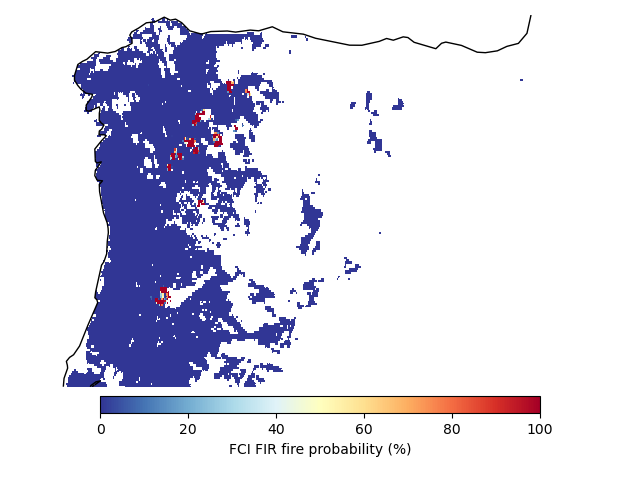

In [19]:
crs = adef.to_cartopy_crs()  # Convert area definition to cartopy CRS object
fig, ax = plt.subplots(subplot_kw={'projection': crs})

ax.coastlines(resolution='50m')

im = ax.imshow(fir_prob.values*100, transform=crs, cmap='RdYlBu_r', extent=crs.bounds, origin='upper', vmin=0, vmax=100, interpolation='none')
plt.axis('off')
cbar = plt.colorbar(im, orientation='horizontal', aspect=25, shrink=0.72, pad=0.02)
cbar.ax.set_xlabel('FCI FIR fire probability (%)')
plt.tight_layout()
plt.show()

This cell repeats the operation for the the fire detection result dataset (`fire_result`)

In [20]:
dataset = "fire_result"  # Dataset to load.
# Load dataset. The upper_right_corner keyword is needed to flip the dataset to "upright" projection
fir_scn.load([dataset], upper_right_corner='NE')
scn_resample=fir_scn.resample(adef)

fir_res = scn_resample[dataset]

SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 




Now plot the result dataset using `matplotlib.pyplot` and `cartopy`. In this case the labels are categorical (discrete) classes, not continuous values. Each pixel in the map belongs to exactly one of the categories.

Since they are discrete classification results, they are represented with a ListedColormap (one distinct color per class) and BoundaryNorm to map the integer values to the correct color interval.

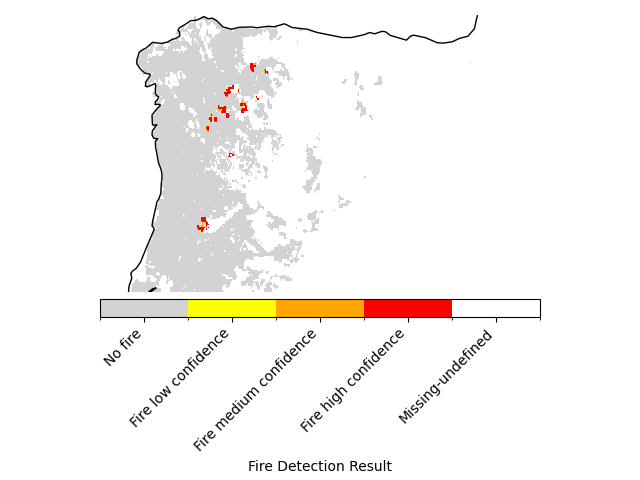

In [21]:
result_labels = {
    0: 'No fire',
    1: 'Fire low confidence',
    2: 'Fire medium confidence',
    3: 'Fire high confidence',
    4: 'Missing-undefined'
}

colors = ['lightgray', 'yellow', 'orange', 'red', 'white']
cmap = ListedColormap(colors)
bounds = [0, 1, 2, 3, 4, 5]  # for 5 classes
norm = BoundaryNorm(bounds, cmap.N)

# Plot
crs = adef.to_cartopy_crs()
fig, ax = plt.subplots(subplot_kw={'projection': crs})

ax.coastlines(resolution='50m')
im = ax.imshow(fir_res, transform=crs, cmap=cmap, norm=norm, extent=crs.bounds, origin='upper', interpolation='nearest')

plt.axis('off')
cbar = plt.colorbar(im, orientation='horizontal', aspect=25, shrink=0.72, pad=0.02, ticks=[0.5, 1.5, 2.5, 3.5, 4.5])
labels = [result_labels[i] for i in range(5)]
cbar.ax.set_xticklabels(labels)
cbar.ax.set_xticklabels(labels, rotation=45, ha='right')
cbar.ax.set_xlabel('Fire Detection Result')

plt.tight_layout()
plt.show()

## Compare FIR data with RGB composites

<div class="alert alert-block alert-success">
<b>Assignment:</b><br />
Let's plot the various variables together: what can you observe? What can you infer about the FIR algorithm properties by comparing the RGBs and the retrievals?
</div>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


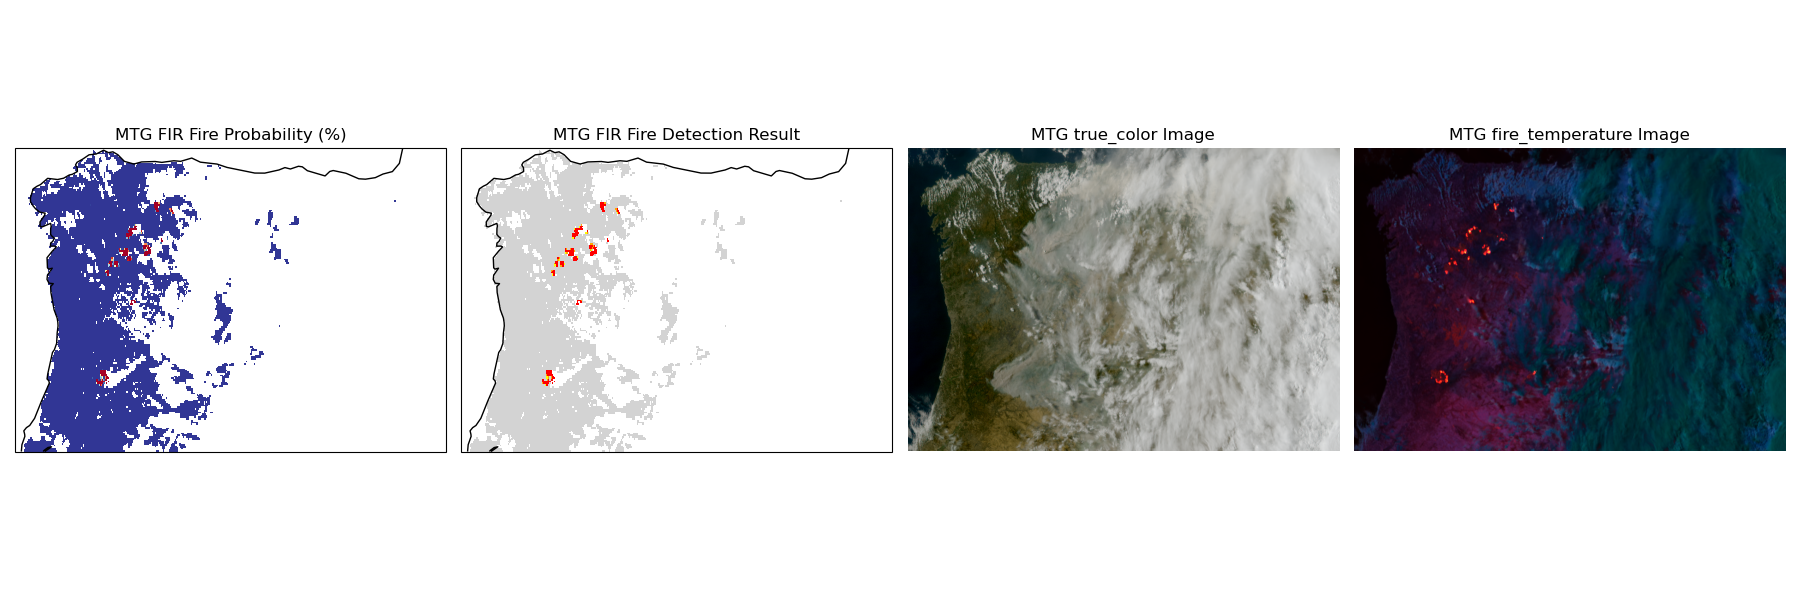

In [22]:
fig, axes = plt.subplots(1, 4, subplot_kw={'projection': crs}, figsize=(18, 6))

# Fire probability map 
ax = axes[0]
ax.coastlines(resolution='50m')
im1 = ax.imshow(fir_prob.values*100, transform=crs, cmap='RdYlBu_r',
                extent=crs.bounds, origin='upper',
                vmin=0, vmax=100, interpolation='none')
ax.set_title("MTG FIR Fire Probability (%)")

# Fire classification result 
ax = axes[1]
ax.coastlines(resolution='50m')
im2 = ax.imshow(fir_res, transform=crs, cmap=cmap, norm=norm,
                extent=crs.bounds, origin='upper', interpolation='nearest')
ax.set_title("MTG FIR Fire Detection Result")

# Satpy scenes 
ax = axes[2]
ax.imshow(composite1_img, transform=crs, extent=crs.bounds, origin='upper')
ax.set_title(f"MTG {composite1} Image")

ax = axes[3]
ax.imshow(composite2_img, transform=crs, extent=crs.bounds, origin='upper')
ax.set_title(f"MTG {composite2} Image")

plt.tight_layout()
plt.show()


## Load and visualise S3 NRT FRP product

The [Copernicus Sentinel-3 SLSTR Near-Real-Time Fire Radiative Power (FRP)](https://navigator.eumetsat.int/product/EO:EUM:DAT:0207) product identifies the location and quantifies the radiative power of any hotspot present on land and ocean, that radiates a heating signal within a pixel size of 1 km<sup>2</sup>.

All  hotspots are identified and characterised within three hours from SLSTR observation sensing time.
The current version of the Near-Real-Time (NRT) S3 FRP processor (Collection 3 available since 4 July 2024) is applicable day and night (over land), and night (over waters for offshore gas flares). The NRT S3 FRP product is pre-operational after having reached lately a high level of quality and maturity, a comprehensive global validation, and positive feedback by experts and users.


### Download S3 NRT FRP product from the Data Store through the EUMDAC API

As with FCI, let's download the S3 data through the EUMDAC wrapper. The `search_bbox` argument allows the filtering of the LEO granules according to our AOI. With LEO, it

In [23]:
search_bbox = ",".join([str(lonmin), str(latmin), str(lonmax), str(latmax)])
collection_ids = ["EO:EUM:DAT:0417"]
download_from_eumdac(start_time, end_time, collection_ids, output_folder,
                     credentials.EUMDAC_CONSUMER_KEY, credentials.EUMDAC_CONSUMER_SECRET, file_endings=file_endings,
                     search_bbox=search_bbox)

[2025-09-19 20:27:08] [DEBUG] download_from_archive: DataStore initialized.
[2025-09-19 20:27:08] [INFO] download_from_archive: Searching for products in area -9.56,39.0,-0.5,43.7914
[2025-09-19 20:27:08] [INFO] download_from_archive: No products found for collection_id EO:EUM:DAT:0417 and time range 2025-08-18 16:00:00 to 2025-08-18 16:10:00.
[2025-09-19 20:27:08] [INFO] download_from_archive: Collection EO:EUM:DAT:0417 not found in the retrieved collections.


<div class="alert alert-block alert-success">
<b>Assignment:</b><br />
The call above, with the default dates, may not have downloaded any data. Why is that the case? And how can we solve this?
</div>

### Process and visualise the S3 NRT FRP product
The first step is to load the data file with xarray's `xr.open_dataset()` function.

Once the data file is loaded, we see that the data file has three dimensions: `columns`, `fires` and `rows`. The data and additional information, such as quality flags or latitude and longitude information, is stored as data variables.

There are 2 variables of interest:
- `FRP_MWIR` - Fire Radiative Power computed from MWIR channel (3.7 um) [MW]
- `FRP_SWIR` - Fire Radiative Power computed from SWIR channel (2.25 um) [MW]

The channels differ in the type of fire they can detect. The `FRP_MWIR` channel detects hotspots with a temperature lower than 1100 Kelvin (typically wildfires), whereas the `FRP_SWIR` channel detects hotspots with higher temperatures above 1100 Kelvin (intense wildfires and gas flares). Both channels can be processes as shown below, in this notebook we will focus only on `FRP_MWIR`.

FRP products mainly use MWIR during the day due to its reliability, while at night, combining MWIR and SWIR helps detect a wider range of fire intensities. SWIR is not yet used during daytime. We select the `FRP_MWIR1km_standard.nc` file to analyse the MWIR detections.

In [24]:
# You can change the folder below if you like, by choosing one from the download logs. The preselected one is recommended as it contains many fires
data_folder = 'S3B_SL_2_FRP____20250818T222627_20250818T223127_20250819T004819_0299_110_101______MAR_O_NR_003.SEN3'

frp_xr = xr.open_dataset(f"./products/{data_folder}/FRP_MWIR1km_standard.nc", engine='netcdf4')
frp_xr

<xarray.Dataset> Size: 12MB
Dimensions:                            (fires_MWIR1km_standard: 529,
                                        rows: 2000, columns: 1500)
Dimensions without coordinates: fires_MWIR1km_standard, rows, columns
Data variables: (12/36)
    i                                  (fires_MWIR1km_standard) int16 1kB ...
    j                                  (fires_MWIR1km_standard) int32 2kB ...
    time                               (fires_MWIR1km_standard) datetime64[ns] 4kB ...
    latitude                           (fires_MWIR1km_standard) float32 2kB ...
    longitude                          (fires_MWIR1km_standard) float32 2kB ...
    FRP_MWIR                           (fires_MWIR1km_standard) float32 2kB ...
    ...                                 ...
    sat_zenith                         (fires_MWIR1km_standard) float32 2kB ...
    sat_azimuth                        (fires_MWIR1km_standard) float32 2kB ...
    eff_across_track_pixel_size        (fires_MWIR1km_standard) float32 2kB ...
    eff_along_track_pixel_size         (fires_MWIR1km_standard) float32 2kB ...
    convert_f3                         (fires_MWIR1km_standard) uint8 529B ...
    flags                              (rows, columns) uint32 12MB ...
Attributes: (12/17)
    title:                  SLSTR Level 2 Product, Fire Radiative Power measu...
    comment:                 
    netCDF_version:         4.2 of Jun 13 2024 12:58:03 $
    product_name:           S3B_SL_2_FRP____20250818T222627_20250818T223127_2...
    institution:            MAR
    source:                 IPF-SL-2-FRP 04.03
    ...                     ...
    absolute_orbit_number:  38103
    start_time:             2025-08-18T22:26:26.858467Z
    stop_time:              2025-08-18T22:31:26.848197Z
    processing_baseline:    FRP_NRT.003.01.00
    track_offset:           998
    start_offset:           3008

In [25]:
lat_frp = frp_xr['latitude']
lon_frp = frp_xr['longitude']
frp_val = frp_xr['FRP_MWIR']

<div class="alert alert-block alert-success">
<b>Assignment:</b><br />
In the following cell, feel free to extract some interesting statistics from the variables.
</div>

In [26]:
# your code to extract statistics


Now, let's plot the S3 detections on top of FCI data! If the selected S3 granule times do not correspond to the FCI times selected previously, just change the times at the top of the notebook and re-run all cells until here.

<div class="alert alert-block alert-warning">
<b>Note:</b><br />
 If the selected S3 granule times do not correspond to the FCI times selected previously, just change the times at the top of the notebook and re-run all cells until here, to have consistent FCI and S3 plots.
</div>
<div class="alert alert-block alert-success">
<b>Assignment:</b><br />
The cell contains the `imshow` command to add any of the FCI plots above as background. To change background, just uncomment the corresponding plot and re-run the cell.
</div>
<div class="alert alert-block alert-success">
<b>Assignment:</b><br />
What can you observe? How does the resolution of the S3 FRP product compare to the FCI? How does the FRP value compare to the FCI results?
</div>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


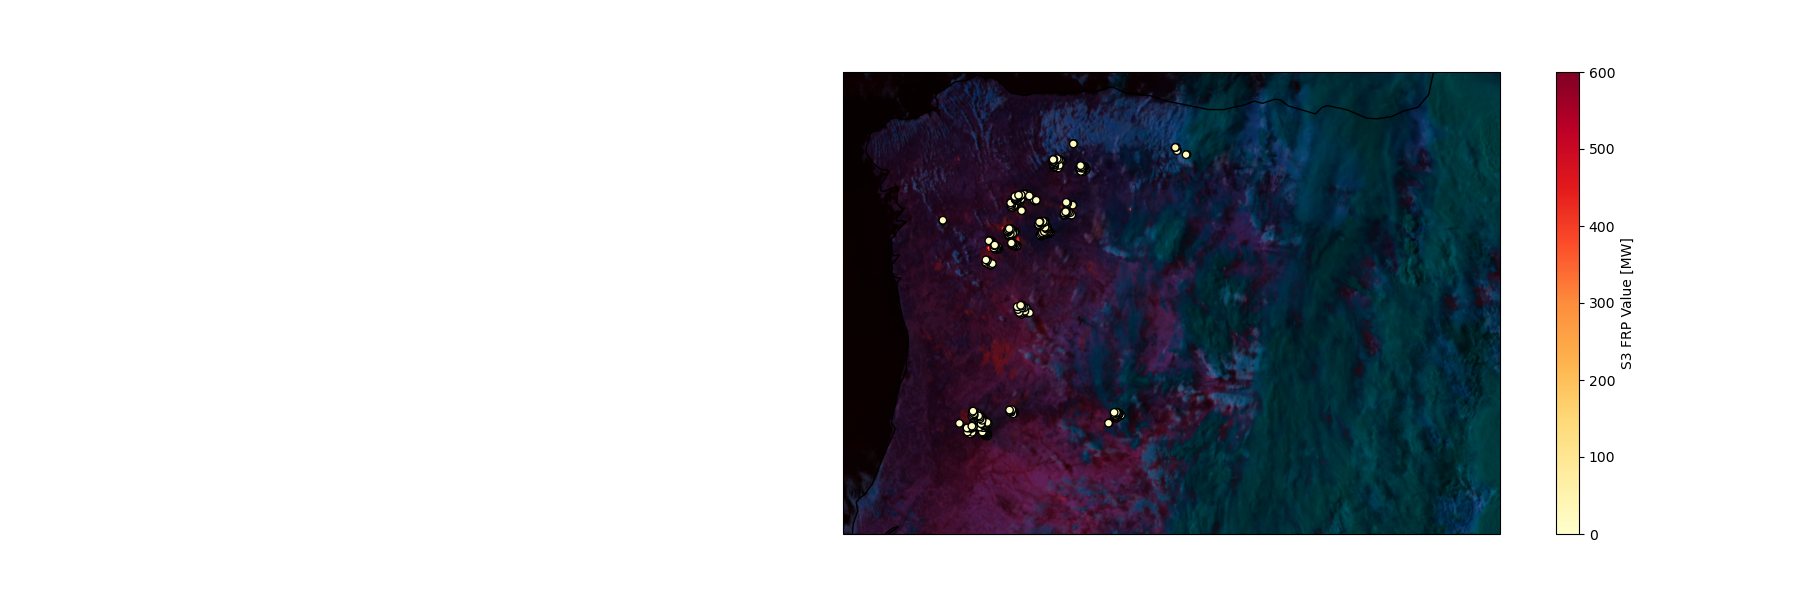

In [27]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': crs}, figsize=(18, 6))
ax.coastlines(resolution='50m')

# ax.imshow(fir_prob.values*100, transform=crs, cmap='RdYlBu_r', extent=crs.bounds, origin='upper', vmin=0, vmax=100, interpolation='none')  # fire probability map
# ax.imshow(fir_res, transform=crs, cmap=cmap, norm=norm, extent=crs.bounds, origin='upper', interpolation='nearest')  # fire classification result
# ax.imshow(composite1_img, transform=crs, origin='upper', extent=crs.bounds)  # satpy composite 1
ax.imshow(composite2_img, transform=crs, origin='upper', extent=crs.bounds)  # satpy composite 2

scatter = ax.scatter(
    lon_frp.values, lat_frp.values,
    c=frp_val,
    cmap='YlOrRd',
    s=30,  # size of markers
    edgecolor='black',  # optional: add a black border around markers
    transform=ccrs.PlateCarree(),
    vmin=0, vmax=600
)

colormap = cm.ScalarMappable(cmap='YlOrRd')
colormap.set_clim(0, 600)
cbar = plt.colorbar(colormap, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('S3 FRP Value [MW]')

<hr>

References:
* https://gitlab.eumetsat.int/eumetlab/data-services/eumdac_data_store/-/blob/master/1_5_MTG_FCI_data_access.ipynb
* https://www.eumetrain.org/resources/andrea-meraner-eumetsat-fci4fires-detecting-and-visualising-wildfires-mtg-fci (slides)
* https://user.eumetsat.int/resources/user-guides/mtg-fci-l2-fir-data-guide#ID-Data-loading-analysis-processing-and-visualisation-tools

<p style="text-align:left;">This project is licensed under the <a href="./LICENSE.TXT">GPL-3.0-or-later</a> </p>